췌장 낭종/비낭종 분류를 위한 BioBERT 모델 (Part 1)코드


In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files  # Colab 환경용

class PancreaticCystDataset(Dataset):
    """췌장 낭종/비낭종 텍스트 데이터셋"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)

        return encoding

def preprocess_text(text):
    """텍스트 전처리 함수"""
    if pd.isna(text):
        return ""

    # 텍스트 정제
    text = str(text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def load_and_prepare_data(cyst_file, noncyst_file, text_column='결론및진단#8', label_column='건강검진결과명#13'):
    """낭종 및 비낭종 데이터 로드 및 준비"""
    # 낭종 데이터 로드
    try:
        cyst_df = pd.read_csv(cyst_file)
        print(f"낭종 데이터 로드 완료: {len(cyst_df)}행")
    except Exception as e:
        print(f"낭종 데이터 로드 오류: {e}")
        try:
            # EUC-KR로 시도
            cyst_df = pd.read_csv(cyst_file, encoding='euc-kr')
            print(f"EUC-KR 인코딩으로 낭종 데이터 로드 완료: {len(cyst_df)}행")
        except:
            print("낭종 데이터 로드 실패")
            return None, None

    # 비낭종 데이터 로드
    try:
        noncyst_df = pd.read_csv(noncyst_file)
        print(f"비낭종 데이터 로드 완료: {len(noncyst_df)}행")
    except Exception as e:
        print(f"비낭종 데이터 로드 오류: {e}")
        try:
            # EUC-KR로 시도
            noncyst_df = pd.read_csv(noncyst_file, encoding='euc-kr')
            print(f"EUC-KR 인코딩으로 비낭종 데이터 로드 완료: {len(noncyst_df)}행")
        except:
            print("비낭종 데이터 로드 실패")
            return None, None

    # 컬럼 존재 여부 확인
    if text_column not in cyst_df.columns or text_column not in noncyst_df.columns:
        print(f"텍스트 컬럼 '{text_column}'이 데이터에 없습니다.")
        print(f"낭종 데이터 컬럼: {cyst_df.columns.tolist()}")
        print(f"비낭종 데이터 컬럼: {noncyst_df.columns.tolist()}")
        return None, None

    # 낭종 데이터 준비 (라벨 0)
    cyst_texts = [preprocess_text(text) for text in cyst_df[text_column]]
    cyst_labels = [0] * len(cyst_texts)  # 낭종 = 0

    # 비낭종 데이터 준비 (라벨 1)
    noncyst_texts = [preprocess_text(text) for text in noncyst_df[text_column]]
    noncyst_labels = [1] * len(noncyst_texts)  # 비낭종 = 1

    # 데이터 결합
    all_texts = cyst_texts + noncyst_texts
    all_labels = cyst_labels + noncyst_labels

    print(f"준비된 데이터: 낭종 {len(cyst_texts)}개, 비낭종 {len(noncyst_texts)}개")

    return all_texts, all_labels

췌장 낭종/비낭종 분류를 위한 BioBERT 모델 (Part 2)

In [ ]:
def evaluate_model(model, test_texts, test_labels, tokenizer, device, batch_size=16, max_length=256):
    """모델 평가 함수"""
    test_dataset = PancreaticCystDataset(test_texts, test_labels, tokenizer, max_length)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            # 소프트맥스로 확률 계산
            probs = torch.nn.functional.softmax(logits, dim=-1)

            preds = logits.argmax(dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # 혼동 행렬
    cm = confusion_matrix(true_labels, predictions)

    # 클래스별 성능 지표
    class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average=None
    )

    # 전체 성능 지표
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )

    print(f"\n테스트 성능:")
    print(f"  정확도: {accuracy:.4f}")
    print(f"  정밀도: {precision:.4f}")
    print(f"  재현율: {recall:.4f}")
    print(f"  F1 점수: {f1:.4f}")

    print("\n클래스별 성능:")
    print(f"  낭종(PCL) (클래스 0):")
    print(f"    정밀도: {class_precision[0]:.4f}")
    print(f"    재현율: {class_recall[0]:.4f}")
    print(f"    F1 점수: {class_f1[0]:.4f}")

    print(f"  비낭종 (클래스 1):")
    print(f"    정밀도: {class_precision[1]:.4f}")
    print(f"    재현율: {class_recall[1]:.4f}")
    print(f"    F1 점수: {class_f1[1]:.4f}")

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['낭종(PCL)', '비낭종'],
        yticklabels=['낭종(PCL)', '비낭종']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities
    }

췌장 낭종/비낭종 분류를 위한 BioBERT 모델 (Part 3)

In [ ]:
def train_biobert_model(texts, labels, output_dir,
                       model_name="dmis-lab/biobert-v1.1",
                       batch_size=16, epochs=8, learning_rate=2e-5, max_length=256,
                       weight_decay=0.01, warmup_ratio=0.1, patience=3):
    """BioBERT 모델 훈련 함수"""
    start_time = time.time()

    # 데이터 분할 (8:1:1 = 훈련:검증:테스트)
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    print(f"훈련 데이터: {len(train_texts)}개")
    print(f"검증 데이터: {len(val_texts)}개")
    print(f"테스트 데이터: {len(test_texts)}개")

    # 클래스 분포 확인
    train_class_dist = np.bincount(train_labels)
    val_class_dist = np.bincount(val_labels)
    test_class_dist = np.bincount(test_labels)

    print(f"훈련 데이터 클래스 분포: 낭종 {train_class_dist[0]}개, 비낭종 {train_class_dist[1]}개")
    print(f"검증 데이터 클래스 분포: 낭종 {val_class_dist[0]}개, 비낭종 {val_class_dist[1]}개")
    print(f"테스트 데이터 클래스 분포: 낭종 {test_class_dist[0]}개, 비낭종 {test_class_dist[1]}개")

    # 모델 및 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 디바이스: {device}")
    model.to(device)

    # 데이터셋 및 데이터로더 생성
    train_dataset = PancreaticCystDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = PancreaticCystDataset(val_texts, val_labels, tokenizer, max_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # 클래스 가중치 계산 (클래스 불균형이 있을 경우 유용)
    class_counts = np.bincount(train_labels)
    class_weights = torch.tensor(
        [len(train_labels) / (class_counts[0] * 2), len(train_labels) / (class_counts[1] * 2)],
        dtype=torch.float
    ).to(device)

    print(f"클래스 가중치: {class_weights}")

    # 옵티마이저 및 스케줄러 설정
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # 훈련 기록
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # 조기 종료 설정
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 훈련 루프
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = range(len(train_dataloader))

        for batch_idx, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            outputs = model(**batch)
            logits = outputs.logits
            labels = batch['labels']

            # 가중치가 적용된 손실 계산
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # 정확도 계산
            predictions = logits.argmax(dim=-1)
            train_correct += (predictions == labels).sum().item()
            train_total += len(labels)

            # 진행상황 출력 (10% 단위)
            if (batch_idx + 1) % max(1, len(train_dataloader) // 10) == 0:
                print(f"  Progress: {batch_idx+1}/{len(train_dataloader)} ({(batch_idx+1)/len(train_dataloader)*100:.1f}%)")

        # 평균 훈련 손실 및 정확도 계산
        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        # 검증 평가
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(**batch)
                logits = outputs.logits
                labels = batch['labels']

                # 가중치가 적용된 손실 계산 (검증에도 동일하게 적용)
                loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
                loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

                val_loss += loss.item()

                # 정확도 계산
                predictions = logits.argmax(dim=-1)
                val_correct += (predictions == labels).sum().item()
                val_total += len(labels)

        # 평균 검증 손실 및 정확도 계산
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # 조기 종료 확인
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0

            # 최적 모델 저장
            model.save_pretrained(os.path.join(output_dir, "best_model"))
            tokenizer.save_pretrained(os.path.join(output_dir, "tokenizer"))

            print(f"  New best model saved!")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break

    # 최종 모델 저장
    model.save_pretrained(os.path.join(output_dir, "final_model"))

    # 모델 평가
    # 가장 좋은 모델 로드
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join(output_dir, "best_model"))
    model.to(device)

    # 테스트 평가
    test_results = evaluate_model(model, test_texts, test_labels, tokenizer, device, batch_size, max_length)

    # 훈련 시간 계산
    training_time = time.time() - start_time
    print(f"총 훈련 시간: {training_time:.2f}초 ({training_time/60:.2f}분)")

    # 학습 과정 시각화
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

    # 결과 요약 저장
    with open(os.path.join(output_dir, 'model_summary.txt'), 'w', encoding='utf-8') as f:
        f.write(f"BioBERT 모델 훈련 결과 요약\n")
        f.write(f"==========================\n\n")
        f.write(f"데이터셋 정보:\n")
        f.write(f"  훈련 데이터: {len(train_texts)}개 (낭종: {train_class_dist[0]}, 비낭종: {train_class_dist[1]})\n")
        f.write(f"  검증 데이터: {len(val_texts)}개 (낭종: {val_class_dist[0]}, 비낭종: {val_class_dist[1]})\n")
        f.write(f"  테스트 데이터: {len(test_texts)}개 (낭종: {test_class_dist[0]}, 비낭종: {test_class_dist[1]})\n\n")

        f.write(f"성능 지표:\n")
        f.write(f"  정확도: {test_results['accuracy']:.4f}\n")
        f.write(f"  정밀도: {test_results['precision']:.4f}\n")
        f.write(f"  재현율: {test_results['recall']:.4f}\n")
        f.write(f"  F1 점수: {test_results['f1']:.4f}\n\n")

        f.write(f"훈련 정보:\n")
        f.write(f"  모델: {model_name}\n")
        f.write(f"  학습률: {learning_rate}\n")
        f.write(f"  배치 크기: {batch_size}\n")
        f.write(f"  최대 에포크: {epochs}\n")
        f.write(f"  조기종료 인내: {patience}\n")
        f.write(f"  훈련 시간: {training_time/60:.2f}분\n")

    return model, tokenizer, history, test_results

췌장 낭종/비낭종 분류를 위한 BioBERT 모델 (Part 4)

낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:


Saving cyst_labeled(336).csv to cyst_labeled(336).csv

비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:


Saving noncyst_labeled(336).csv to noncyst_labeled(336).csv

레이블 없는 데이터를 예측하시겠습니까? (y/n): y

레이블 없는 데이터 파일을 업로드하세요:


Saving pancreas_1300data.csv to pancreas_1300data.csv

기본 텍스트 컬럼명('결론및진단#8')을 변경하시겠습니까? (y/n): n
낭종 데이터 로드 완료: 336행
비낭종 데이터 로드 완료: 336행
준비된 데이터: 낭종 336개, 비낭종 336개

훈련 매개변수를 사용자 지정하시겠습니까? (y/n): n
훈련 데이터: 537개
검증 데이터: 67개
테스트 데이터: 68개
훈련 데이터 클래스 분포: 낭종 268개, 비낭종 269개
검증 데이터 클래스 분포: 낭종 34개, 비낭종 33개
테스트 데이터 클래스 분포: 낭종 34개, 비낭종 34개


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


사용 디바이스: cuda


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

클래스 가중치: tensor([1.0019, 0.9981], device='cuda:0')
Epoch 1/10
  Progress: 3/34 (8.8%)
  Progress: 6/34 (17.6%)
  Progress: 9/34 (26.5%)
  Progress: 12/34 (35.3%)
  Progress: 15/34 (44.1%)
  Progress: 18/34 (52.9%)
  Progress: 21/34 (61.8%)
  Progress: 24/34 (70.6%)
  Progress: 27/34 (79.4%)
  Progress: 30/34 (88.2%)
  Progress: 33/34 (97.1%)
  Train Loss: 0.6795, Train Accuracy: 0.5587
  Val Loss: 0.6415, Val Accuracy: 0.7463
  New best model saved!
Epoch 2/10
  Progress: 3/34 (8.8%)
  Progress: 6/34 (17.6%)
  Progress: 9/34 (26.5%)
  Progress: 12/34 (35.3%)
  Progress: 15/34 (44.1%)
  Progress: 18/34 (52.9%)
  Progress: 21/34 (61.8%)
  Progress: 24/34 (70.6%)
  Progress: 27/34 (79.4%)
  Progress: 30/34 (88.2%)
  Progress: 33/34 (97.1%)
  Train Loss: 0.5420, Train Accuracy: 0.7467
  Val Loss: 0.4902, Val Accuracy: 0.8060
  New best model saved!
Epoch 3/10
  Progress: 3/34 (8.8%)
  Progress: 6/34 (17.6%)
  Progress: 9/34 (26.5%)
  Progress: 12/34 (35.3%)
  Progress: 15/34 (44.1%)
  Prog

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45229 (\N{HANGUL SYLLABLE NANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45229 (\N{HANGUL SYLLABLE NANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{

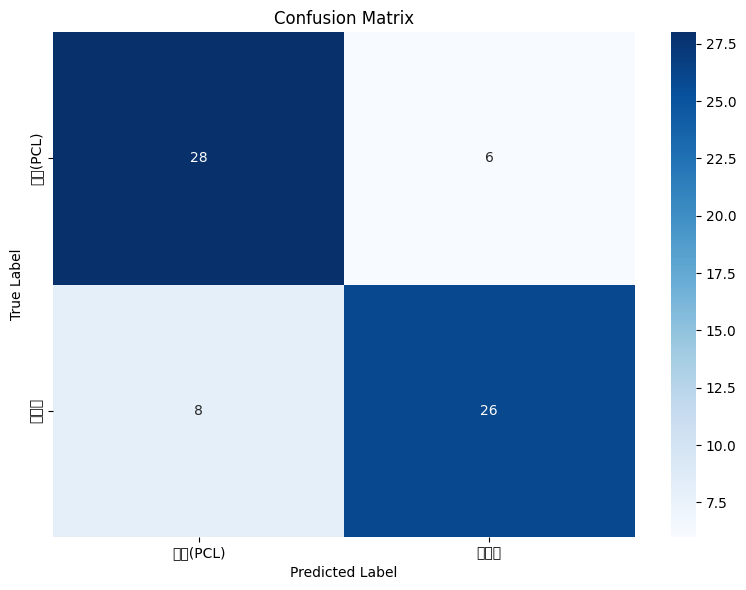

총 훈련 시간: 48.41초 (0.81분)


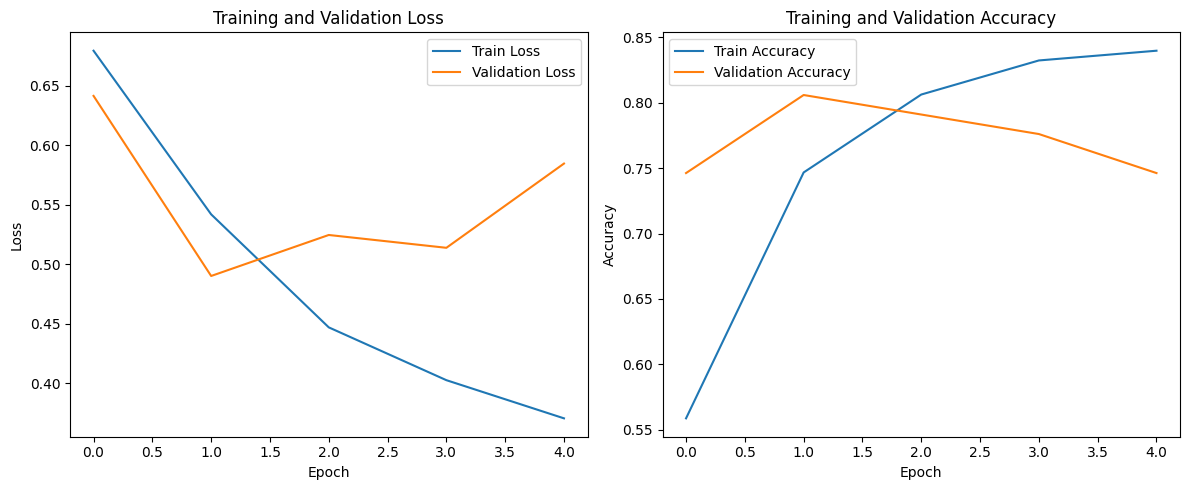


예측 결과 분포:
predicted_label
낭종(PCL)    923
비낭종        379
Name: count, dtype: int64
예측 결과가 './pancreatic_cyst_classifier/unlabeled_predictions.csv'에 저장되었습니다.

BioBERT 모델 훈련 및 예측 완료!
모델이 './pancreatic_cyst_classifier' 디렉토리에 저장되었습니다.

결과 파일 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size=16, max_length=256):
    """레이블 없는 데이터 예측 함수"""
    # 텍스트 정제
    texts = []
    for _, row in unlabeled_df.iterrows():
        text = preprocess_text(row[text_column])
        texts.append(text)

    # 토큰화
    dataset = PancreaticCystDataset(texts, [0] * len(texts), tokenizer, max_length)  # 더미 레이블
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # 예측
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            # 레이블 제외
            batch_inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

            outputs = model(**batch_inputs)
            logits = outputs.logits

            # 소프트맥스로 확률 계산
            probs = torch.nn.functional.softmax(logits, dim=-1)

            # 예측 클래스
            preds = logits.argmax(dim=-1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # 결과 저장
    results_df = unlabeled_df.copy()
    results_df['predicted_class'] = predictions
    results_df['predicted_label'] = ["낭종(PCL)" if p == 0 else "비낭종" for p in predictions]
    results_df['confidence_cyst'] = [p[0] for p in probabilities]
    results_df['confidence_noncyst'] = [p[1] for p in probabilities]

    # 분포 확인
    print("\n예측 결과 분포:")
    print(results_df['predicted_label'].value_counts())

    # 파일 저장
    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"예측 결과가 '{output_path}'에 저장되었습니다.")

    return results_df

def main():
    """메인 실행 함수"""
    # 파일 업로드 (Colab 환경)
    print("낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:")
    uploaded_cyst = files.upload()
    cyst_file = list(uploaded_cyst.keys())[0]

    print("\n비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:")
    uploaded_noncyst = files.upload()
    noncyst_file = list(uploaded_noncyst.keys())[0]

    # 레이블 없는 데이터 (선택적)
    upload_unlabeled = input("\n레이블 없는 데이터를 예측하시겠습니까? (y/n): ").lower() == 'y'
    unlabeled_file = None
    unlabeled_df = None

    if upload_unlabeled:
        print("\n레이블 없는 데이터 파일을 업로드하세요:")
        uploaded_unlabeled = files.upload()
        if uploaded_unlabeled:
            unlabeled_file = list(uploaded_unlabeled.keys())[0]
            try:
                unlabeled_df = pd.read_csv(unlabeled_file)
            except:
                try:
                    unlabeled_df = pd.read_csv(unlabeled_file, encoding='euc-kr')
                except Exception as e:
                    print(f"레이블 없는 데이터 로드 실패: {e}")
                    unlabeled_df = None

    # 컬럼명 설정
    text_column = '결론및진단#8'  # 기본값

    # 사용자 지정 컬럼명 (선택적)
    custom_columns = input("\n기본 텍스트 컬럼명('결론및진단#8')을 변경하시겠습니까? (y/n): ").lower() == 'y'
    if custom_columns:
        text_column = input("텍스트 컬럼명을 입력하세요: ")

    # 출력 디렉토리 설정
    output_dir = "./pancreatic_cyst_classifier"

    # 데이터 로드 및 준비
    texts, labels = load_and_prepare_data(cyst_file, noncyst_file, text_column)

    if texts is None or labels is None:
        print("데이터 준비 실패. 프로그램을 종료합니다.")
        return

    # 훈련 매개변수 설정
    batch_size = 16
    epochs = 10
    learning_rate = 2e-5
    max_length = 256
    weight_decay = 0.01
    warmup_ratio = 0.1
    patience = 3

    # 사용자 지정 매개변수 (선택적)
    custom_params = input("\n훈련 매개변수를 사용자 지정하시겠습니까? (y/n): ").lower() == 'y'
    if custom_params:
        try:
            batch_size = int(input(f"배치 크기 (기본값: {batch_size}): ") or batch_size)
            epochs = int(input(f"최대 에포크 수 (기본값: {epochs}): ") or epochs)
            learning_rate = float(input(f"학습률 (기본값: {learning_rate}): ") or learning_rate)
            max_length = int(input(f"최대 시퀀스 길이 (기본값: {max_length}): ") or max_length)
            patience = int(input(f"조기 종료 인내 (기본값: {patience}): ") or patience)
        except ValueError as e:
            print(f"잘못된 입력. 기본값을 사용합니다: {e}")

    # 모델 훈련
    model, tokenizer, history, test_results = train_biobert_model(
        texts,
        labels,
        output_dir,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        max_length=max_length,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        patience=patience
    )

    # 레이블 없는 데이터 예측 (있는 경우)
    if unlabeled_df is not None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if text_column not in unlabeled_df.columns:
            print(f"경고: 레이블 없는 데이터에 '{text_column}' 컬럼이 없습니다.")
            print(f"사용 가능한 컬럼: {unlabeled_df.columns.tolist()}")
            text_column = input("사용할 텍스트 컬럼명을 입력하세요: ")

        predict_unlabeled_data(
            model,
            tokenizer,
            unlabeled_df,
            text_column,
            os.path.join(output_dir, "unlabeled_predictions.csv"),
            device,
            batch_size=batch_size,
            max_length=max_length
        )

    print("\nBioBERT 모델 훈련 및 예측 완료!")
    print(f"모델이 '{output_dir}' 디렉토리에 저장되었습니다.")

    # 결과 파일 다운로드 (Colab 환경)
    print("\n결과 파일 다운로드 중...")
    files.download(os.path.join(output_dir, 'model_summary.txt'))
    files.download(os.path.join(output_dir, 'training_history.png'))

    if unlabeled_df is not None:
        files.download(os.path.join(output_dir, "unlabeled_predictions.csv"))

if __name__ == "__main__":
    main()

In [ ]:
!pip install transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.0
    Uninstalling transformers-4.35.0:
      Successfully uninstalled transformers-4.35.0


In [ ]:
import transformers

print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments

try:
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        warmup_ratio=0.1,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir="./logs",
        logging_steps=10,
    )
except TypeError as e:
    print(f"오류 발생: {e}")

오류 발생: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


In [ ]:
!rm -rf ~/.cache/huggingface/transformers

In [ ]:
!pip install transformers==4.51.3

In [ ]:
from transformers import TrainingArguments

try:
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        warmup_ratio=0.1,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir="./logs",
        logging_steps=10,
    )
except TypeError as e:
    print(f"오류 발생: {e}")

오류 발생: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


In [ ]:
!pip install transformers==4.35.0  # 예시: 이전 버전 설치
!pip install transformers  # 최신 개발 버전 설치

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.30.2
    Uninstalling huggingface-hub-0.30.2:
      Successfully uninstalled huggingface-hub-0.30.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [ ]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DataCollatorWithPadding
import os
from google.colab import files

def preprocess_text(text):
    """텍스트 전처리 함수 (예시 - 실제 구현 필요)"""
    if isinstance(text, str):
        text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  # 특수 문자 제거
        text = re.sub(r'\s+', ' ', text).strip()  # 연속 공백 제거
        return text
    else:
        return ""  # 또는 적절한 기본값 반환

class PancreaticCystDataset(Dataset):
    """PyTorch Dataset 클래스 (예시 - 실제 구현 필요)"""
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is a string
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def load_and_prepare_data(cyst_file, noncyst_file, text_column):
    """데이터 로드 및 준비 함수 (예시 - 실제 구현 필요)"""
    try:
        cyst_df = pd.read_csv(cyst_file)
        noncyst_df = pd.read_csv(noncyst_file)
    except Exception as e:
        print(f"데이터 로드 오류: {e}")
        return None, None

    cyst_df['label'] = 0  # 낭종(PCL)
    noncyst_df['label'] = 1  # 비낭종

    texts = list(cyst_df[text_column]) + list(noncyst_df[text_column])
    labels = list(cyst_df['label']) + list(noncyst_df['label'])

    return texts, labels

def compute_metrics(p):
    """평가 지표 계산 함수 (예시 - 실제 구현 필요)"""
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_biobert_model(texts, labels, output_dir, batch_size=16, epochs=10, learning_rate=2e-5, max_length=256, weight_decay=0.01, warmup_ratio=0.1, patience=3):
    """BioBERT 모델 훈련 함수 (예시 - 실제 구현 필요)"""

    # 1. 모델 및 토크나이저 로드
    model_name = "dmis-lab/biobert-base-cased-v1.1"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # 2. 데이터셋 준비
    train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

    train_dataset = PancreaticCystDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = PancreaticCystDataset(test_texts, test_labels, tokenizer, max_length)

    # 3. 훈련
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        save_strategy="epoch",
        evaluation_strategy="epoch",  # 추가: save_strategy와 동일하게 설정
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir="./logs",
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    trainer.train()

    # 4. 테스트
    test_results = trainer.evaluate(test_dataset)

    return model, tokenizer, trainer.state.log_history, test_results

def predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size=16, max_length=256):
    """레이블 없는 데이터 예측 함수"""
    # 텍스트 정제
    texts = []
    for _, row in unlabeled_df.iterrows():
        text = preprocess_text(row[text_column])
        texts.append(text)

    # 토큰화
    dataset = PancreaticCystDataset(texts, [0] * len(texts), tokenizer, max_length)  # 더미 레이블
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # 예측
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            # 레이블 제외
            batch_inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

            outputs = model(**batch_inputs)
            logits = outputs.logits

            # 소프트맥스로 확률 계산
            probs = torch.nn.functional.softmax(logits, dim=-1)

            # 예측 클래스
            preds = logits.argmax(dim=-1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # 결과 저장
    results_df = unlabeled_df.copy()
    results_df['predicted_class'] = predictions
    results_df['predicted_label'] = ["낭종(PCL)" if p == 0 else "비낭종" for p in predictions]
    results_df['confidence_cyst'] = [p[0] for p in probabilities]
    results_df['confidence_noncyst'] = [p[1] for p in probabilities]

    # 분포 확인
    print("\n예측 결과 분포:")
    print(results_df['predicted_label'].value_counts())

    # 파일 저장
    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"예측 결과가 '{output_path}'에 저장되었습니다.")

    return results_df

def main():
    """메인 실행 함수"""
    try:
        # 파일 업로드 (Colab 환경)
        print("낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:")
        uploaded_cyst = files.upload()
        cyst_file = list(uploaded_cyst.keys())[0]

        print("\n비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:")
        uploaded_noncyst = files.upload()
        noncyst_file = list(uploaded_noncyst.keys())[0]

        # 레이블 없는 데이터 (선택적)
        upload_unlabeled = input("\n레이블 없는 데이터를 예측하시겠습니까? (y/n): ").lower() == 'y'
        unlabeled_file = None
        unlabeled_df = None

        if upload_unlabeled:
            print("\n레이블 없는 데이터 파일을 업로드하세요:")
            uploaded_unlabeled = files.upload()
            if uploaded_unlabeled:
                unlabeled_file = list(uploaded_unlabeled.keys())[0]
                try:
                    unlabeled_df = pd.read_csv(unlabeled_file)
                except:
                    try:
                        unlabeled_df = pd.read_csv(unlabeled_file, encoding='euc-kr')
                    except Exception as e:
                        print(f"레이블 없는 데이터 로드 실패: {e}")
                        unlabeled_df = None

        # 컬럼명 설정
        text_column = '결론및진단#8'  # 기본값

        # 사용자 지정 컬럼명 (선택적)
        custom_columns = input("\n기본 텍스트 컬럼명('결론및진단#8')을 변경하시겠습니까? (y/n): ").lower() == 'y'
        if custom_columns:
            text_column = input("텍스트 컬럼명을 입력하세요: ")

        # 출력 디렉토리 설정
        output_dir = "./pancreatic_cyst_classifier"

        # 데이터 로드 및 준비
        texts, labels = load_and_prepare_data(cyst_file, noncyst_file, text_column)

        if texts is None or labels is None:
            print("데이터 준비 실패. 프로그램을 종료합니다.")
            return

        # 훈련 매개변수 설정
        batch_size = 16
        epochs = 10
        learning_rate = 2e-5
        max_length = 256
        weight_decay = 0.01
        warmup_ratio = 0.1
        patience = 3

        # 사용자 지정 매개변수 (선택적)
        custom_params = input("\n훈련 매개변수를 사용자 지정하시겠습니까? (y/n): ").lower() == 'y'
        if custom_params:
            try:
                batch_size = int(input(f"배치 크기 (기본값: {batch_size}): ") or batch_size)
                epochs = int(input(f"최대 에포크 수 (기본값: {epochs}): ") or epochs)
                learning_rate = float(input(f"학습률 (기본값: {learning_rate}): ") or learning_rate)
                max_length = int(input(f"최대 시퀀스 길이 (기본값: {max_length}): ") or max_length)
                patience = int(input(f"조기 종료 인내 (기본값: {patience}): ") or patience)
            except ValueError as e:
                print(f"잘못된 입력. 기본값을 사용합니다: {e}")

        # 모델 훈련
        model, tokenizer, history, test_results = train_biobert_model(
            texts,
            labels,
            output_dir,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            max_length=max_length,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            patience=patience
        )

        # 레이블 없는 데이터 예측 (선택적)
        if upload_unlabeled and unlabeled_df is not None:
            output_path = os.path.join(output_dir, "unlabeled_predictions.csv")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 가능하면 사용
            model.to(device)  # 모델을 해당 장치로 이동

            predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size, max_length)

        # 훈련 이력 및 테스트 결과 출력
        print("\n훈련 이력:")
        for key, value in history.items():
            print(f"- {key}: {value}")

        print("\n테스트 결과:")
        for key, value in test_results.items():
            print(f"- {key}: {value}")

    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:


Saving cyst_labeled(336).csv to cyst_labeled(336) (4).csv

비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:


Saving noncyst_labeled(336).csv to noncyst_labeled(336) (6).csv

레이블 없는 데이터를 예측하시겠습니까? (y/n): y

레이블 없는 데이터 파일을 업로드하세요:


Saving pancreas_1300data.csv to pancreas_1300data (4).csv

기본 텍스트 컬럼명('결론및진단#8')을 변경하시겠습니까? (y/n): n

훈련 매개변수를 사용자 지정하시겠습니까? (y/n): n


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


오류 발생: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


Traceback (most recent call last):
  File "<ipython-input-1-b62581e4c619>", line 250, in main
    model, tokenizer, history, test_results = train_biobert_model(
                                              ^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-1-b62581e4c619>", line 94, in train_biobert_model
    training_args = TrainingArguments(
                    ^^^^^^^^^^^^^^^^^^
TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_text(text):
    """텍스트 전처리 함수"""
    if isinstance(text, str):
        text = text.replace('\r', ' ').replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

class PancreaticCystDataset(Dataset):
    """췌장 낭종/비낭종 텍스트 데이터셋"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def load_and_prepare_data(cyst_file, noncyst_file, text_column, label_column):
    """데이터 로드 및 준비 함수"""
    try:
        cyst_df = pd.read_csv(cyst_file)
        noncyst_df = pd.read_csv(noncyst_file)
    except FileNotFoundError as e:
        print(f"데이터 로드 오류: {e}")
        return None, None

    cyst_df['label'] = 0  # 낭종(PCL)
    noncyst_df['label'] = 1  # 비낭종

    texts = list(cyst_df[text_column]) + list(noncyst_df[text_column])
    labels = list(cyst_df['label']) + list(noncyst_df['label'])

    return texts, labels

def compute_metrics(p):
    """평가 지표 계산 함수"""
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_biobert_model(texts, labels, output_dir, model_name="dmis-lab/biobert-base-cased-v1.1",
                        batch_size=16, epochs=10, learning_rate=2e-5, max_length=256,
                        weight_decay=0.01, warmup_ratio=0.1, patience=3):
    """BioBERT 모델 훈련 함수"""

    # 1. 모델 및 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 2. 데이터셋 준비
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_dataset = PancreaticCystDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = PancreaticCystDataset(test_texts, test_labels, tokenizer, max_length)

    # 3. 훈련 설정
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir="./logs",
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    # 4. 훈련
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    print(f"\n총 훈련 시간: {training_time:.2f}초 ({training_time / 60:.2f}분)")

    # 5. 테스트
    test_results = trainer.evaluate(test_dataset)
    print("\n테스트 결과:")
    print(test_results)

    # 6. 훈련 이력 시각화
    history = trainer.state.log_history
    plot_training_history(history, output_dir)

    return model, tokenizer, history, test_results

def plot_training_history(history, output_dir):
    """훈련 이력 시각화 함수"""
    train_loss = [h['loss'] for h in history if 'loss' in h]
    val_loss = [h['eval_loss'] for h in history if 'eval_loss' in h]
    train_acc = [h['train_accuracy'] for h in history if 'train_accuracy' in h]
    val_acc = [h['eval_accuracy'] for h in history if 'eval_accuracy' in h]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

def predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size=16, max_length=256):
    """레이블 없는 데이터 예측 함수"""

    # 1. 텍스트 전처리
    texts = [preprocess_text(row[text_column]) for _, row in unlabeled_df.iterrows()]

    # 2. 데이터셋 및 데이터로더 생성
    dataset = PancreaticCystDataset(texts, [0] * len(texts), tokenizer, max_length)  # 더미 레이블
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # 3. 예측
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            preds = logits.argmax(dim=-1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # 4. 결과 저장
    results_df = unlabeled_df.copy()
    results_df['predicted_class'] = predictions
    results_df['predicted_label'] = ["낭종(PCL)" if p == 0 else "비낭종" for p in predictions]
    results_df['confidence_cyst'] = [p[0] for p in probabilities]
    results_df['confidence_noncyst'] = [p[1] for p in probabilities]

    # 5. 분포 확인 및 파일 저장
    print("\n예측 결과 분포:")
    print(results_df['predicted_label'].value_counts())

    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"예측 결과가 '{output_path}'에 저장되었습니다.")

    return results_df

def main():
    """메인 실행 함수"""

    # 1. 파일 업로드
    print("낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:")
    uploaded_cyst = files.upload()
    cyst_file = list(uploaded_cyst.keys())[0]

    print("\n비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:")
    uploaded_noncyst = files.upload()
    noncyst_file = list(uploaded_noncyst.keys())[0]

    # 2. 레이블 없는 데이터 업로드 (선택적)
    upload_unlabeled = input("\n레이블 없는 데이터를 예측하시겠습니까? (y/n): ").lower() == 'y'
    unlabeled_file = None
    unlabeled_df = None

    if upload_unlabeled:
        print("\n레이블 없는 데이터 파일을 업로드하세요:")
        uploaded_unlabeled = files.upload()
        if uploaded_unlabeled:
            unlabeled_file = list(uploaded_unlabeled.keys())[0]
            try:
                unlabeled_df = pd.read_csv(unlabeled_file)
            except:
                try:
                    unlabeled_df = pd.read_csv(unlabeled_file, encoding='euc-kr')
                except Exception as e:
                    print(f"레이블 없는 데이터 로드 실패: {e}")
                    unlabeled_df = None

    # 3. 컬럼명 설정
    text_column = '결론및진단#8'  # 기본값
    label_column = '건강검진결과명#13' # 기본값

    custom_columns = input("\n기본 컬럼명을 변경하시겠습니까? (y/n): ").lower() == 'y'
    if custom_columns:
        text_column = input("텍스트 컬럼명을 입력하세요: ")
        label_column = input("레이블 컬럼명을 입력하세요: ")

    # 4. 출력 디렉토리 설정
    output_dir = "./pancreatic_cyst_classifier"
    os.makedirs(output_dir, exist_ok=True)

    # 5. 데이터 로드 및 준비
    texts, labels = load_and_prepare_data(cyst_file, noncyst_file, text_column, label_column)

    if texts is None or labels is None:
        print("데이터 준비 실패. 프로그램을 종료합니다.")
        return

    # 6. 모델 훈련 매개변수 설정
    batch_size = 16
    epochs = 10
    learning_rate = 2e-5
    max_length = 256
    weight_decay = 0.01
    warmup_ratio = 0.1
    patience = 3

    custom_params = input("\n훈련 매개변수를 사용자 지정하시겠습니까? (y/n): ").lower() == 'y'
    if custom_params:
        try:
            batch_size = int(input(f"배치 크기 (기본값: {batch_size}): ") or batch_size)
            epochs = int(input(f"최대 에포크 수 (기본값: {epochs}): ") or epochs)
            learning_rate = float(input(f"학습률 (기본값: {learning_rate}): ") or learning_rate)
            max_length = int(input(f"최대 시퀀스 길이 (기본값: {max_length}): ") or max_length)
            patience = int(input(f"조기 종료 인내 (기본값: {patience}): ") or patience)
        except ValueError as e:
            print(f"잘못된 입력. 기본값을 사용합니다: {e}")

    # 7. BioBERT 모델 훈련
    model, tokenizer, history, test_results = train_biobert_model(
        texts,
        labels,
        output_dir,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        max_length=max_length,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        patience=patience
    )

    # 8. 레이블 없는 데이터 예측 (선택적)
    if upload_unlabeled and unlabeled_df is not None:
        output_path = os.path.join(output_dir, "unlabeled_predictions.csv")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size, max_length)

    # 9. 최종 결과 출력
    print("\nBioBERT 모델 훈련 및 예측 완료!")
    print("\n훈련 이력:")
    for key, value in history.items():
        print(f"- {key}: {value}")

    print("\n테스트 결과:")
    for key, value in test_results.items():
        print(f"- {key}: {value}")

if __name__ == "__main__":
    import time
    from google.colab import files

    main()

낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:


Saving cyst_labeled(336).csv to cyst_labeled(336) (5).csv

비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:


Saving noncyst_labeled(336).csv to noncyst_labeled(336) (7).csv

레이블 없는 데이터를 예측하시겠습니까? (y/n): y

레이블 없는 데이터 파일을 업로드하세요:


Saving pancreas_1300data.csv to pancreas_1300data (5).csv

기본 컬럼명을 변경하시겠습니까? (y/n): n

훈련 매개변수를 사용자 지정하시겠습니까? (y/n): n


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments

try:
    training_args = TrainingArguments(
        output_dir="./results",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    print("TrainingArguments 생성 성공!")
except TypeError as e:
    print(f"오류 발생: {e}")

ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.NO
- Save strategy: SaveStrategy.EPOCH

In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_text(text):
    """텍스트 전처리 함수"""
    if isinstance(text, str):
        text = text.replace('\r', ' ').replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

class PancreaticCystDataset(Dataset):
    """췌장 낭종/비낭종 텍스트 데이터셋"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def load_and_prepare_data(cyst_file, noncyst_file, text_column, label_column):
    """데이터 로드 및 준비 함수"""
    try:
        cyst_df = pd.read_csv(cyst_file)
        noncyst_df = pd.read_csv(noncyst_file)
    except FileNotFoundError as e:
        print(f"데이터 로드 오류: {e}")
        return None, None

    cyst_df['label'] = 0  # 낭종(PCL)
    noncyst_df['label'] = 1  # 비낭종

    texts = list(cyst_df[text_column]) + list(noncyst_df[text_column])
    labels = list(cyst_df['label']) + list(noncyst_df['label'])

    return texts, labels

def compute_metrics(p):
    """평가 지표 계산 함수"""
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_biobert_model(texts, labels, output_dir, model_name="dmis-lab/biobert-base-cased-v1.1",
                        batch_size=16, epochs=10, learning_rate=2e-5, max_length=256,
                        weight_decay=0.01, warmup_ratio=0.1, patience=3):
    """BioBERT 모델 훈련 함수"""

    # 1. 모델 및 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 2. 데이터셋 준비
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_dataset = PancreaticCystDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = PancreaticCystDataset(test_texts, test_labels, tokenizer, max_length)

    # 3. 훈련 설정
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        save_strategy="epoch",
        # evaluation_strategy="epoch",  # 이 줄을 제거
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_dir="./logs",
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    # 4. 훈련
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    print(f"\n총 훈련 시간: {training_time:.2f}초 ({training_time / 60:.2f}분)")

    # 5. 테스트
    test_results = trainer.evaluate(test_dataset)
    print("\n테스트 결과:")
    print(test_results)

    # 6. 훈련 이력 시각화
    history = trainer.state.log_history
    plot_training_history(history, output_dir)

    return model, tokenizer, history, test_results

def plot_training_history(history, output_dir):
    """훈련 이력 시각화 함수"""
    train_loss = [h['loss'] for h in history if 'loss' in h]
    val_loss = [h['eval_loss'] for h in history if 'eval_loss' in h]
    train_acc = [h['train_accuracy'] for h in history if 'train_accuracy' in h]
    val_acc = [h['eval_accuracy'] for h in history if 'eval_accuracy' in h]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

def predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size=16, max_length=256):
    """레이블 없는 데이터 예측 함수"""

    # 1. 텍스트 전처리
    texts = [preprocess_text(row[text_column]) for _, row in unlabeled_df.iterrows()]

    # 2. 데이터셋 및 데이터로더 생성
    dataset = PancreaticCystDataset(texts, [0] * len(texts), tokenizer, max_length)  # 더미 레이블
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # 3. 예측
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            preds = logits.argmax(dim=-1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # 4. 결과 저장
    results_df = unlabeled_df.copy()
    results_df['predicted_class'] = predictions
    results_df['predicted_label'] = ["낭종(PCL)" if p == 0 else "비낭종" for p in predictions]
    results_df['confidence_cyst'] = [p[0] for p in probabilities]
    results_df['confidence_noncyst'] = [p[1] for p in probabilities]

    # 5. 분포 확인 및 파일 저장
    print("\n예측 결과 분포:")
    print(results_df['predicted_label'].value_counts())

    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"예측 결과가 '{output_path}'에 저장되었습니다.")

    return results_df

def main():
    """메인 실행 함수"""

    # 1. 파일 업로드
    print("낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:")
    uploaded_cyst = files.upload()
    cyst_file = list(uploaded_cyst.keys())[0]

    print("\n비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:")
    uploaded_noncyst = files.upload()
    noncyst_file = list(uploaded_noncyst.keys())[0]

    # 2. 레이블 없는 데이터 업로드 (선택적)
    upload_unlabeled = input("\n레이블 없는 데이터를 예측하시겠습니까? (y/n): ").lower() == 'y'
    unlabeled_file = None
    unlabeled_df = None

    if upload_unlabeled:
        print("\n레이블 없는 데이터 파일을 업로드하세요:")
        uploaded_unlabeled = files.upload()
        if uploaded_unlabeled:
            unlabeled_file = list(uploaded_unlabeled.keys())[0]
            try:
                unlabeled_df = pd.read_csv(unlabeled_file)
            except:
                try:
                    unlabeled_df = pd.read_csv(unlabeled_file, encoding='euc-kr')
                except Exception as e:
                    print(f"레이블 없는 데이터 로드 실패: {e}")
                    unlabeled_df = None

    # 3. 컬럼명 설정
    text_column = '결론및진단#8'  # 기본값
    label_column = '건강검진결과명#13' # 기본값

    custom_columns = input("\n기본 컬럼명을 변경하시겠습니까? (y/n): ").lower() == 'y'
    if custom_columns:
        text_column = input("텍스트 컬럼명을 입력하세요: ")
        label_column = input("레이블 컬럼명을 입력하세요: ")

    # 4. 출력 디렉토리 설정
    output_dir = "./pancreatic_cyst_classifier"
    os.makedirs(output_dir, exist_ok=True)

    # 5. 데이터 로드 및 준비
    texts, labels = load_and_prepare_data(cyst_file, noncyst_file, text_column, label_column)

    if texts is None or labels is None:
        print("데이터 준비 실패. 프로그램을 종료합니다.")
        return

    # 6. 모델 훈련 매개변수 설정
    batch_size = 16
    epochs = 10
    learning_rate = 2e-5
    max_length = 256
    weight_decay = 0.01
    warmup_ratio = 0.1
    patience = 3

    custom_params = input("\n훈련 매개변수를 사용자 지정하시겠습니까? (y/n): ").lower() == 'y'
    if custom_params:
        try:
            batch_size = int(input(f"배치 크기 (기본값: {batch_size}): ") or batch_size)
            epochs = int(input(f"최대 에포크 수 (기본값: {epochs}): ") or epochs)
            learning_rate = float(input(f"학습률 (기본값: {learning_rate}): ") or learning_rate)
            max_length = int(input(f"최대 시퀀스 길이 (기본값: {max_length}): ") or max_length)
            patience = int(input(f"조기 종료 인내 (기본값: {patience}): ") or patience)
        except ValueError as e:
            print(f"잘못된 입력. 기본값을 사용합니다: {e}")

    # 7. BioBERT 모델 훈련
    model, tokenizer, history, test_results = train_biobert_model(
        texts,
        labels,
        output_dir,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        max_length=max_length,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        patience=patience
    )

    # 8. 레이블 없는 데이터 예측 (선택적)
    if upload_unlabeled and unlabeled_df is not None:
        output_path = os.path.join(output_dir, "unlabeled_predictions.csv")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        predict_unlabeled_data(model, tokenizer, unlabeled_df, text_column, output_path, device, batch_size, max_length)

    # 9. 최종 결과 출력
    print("\nBioBERT 모델 훈련 및 예측 완료!")
    print("\n훈련 이력:")
    for key, value in history.items():
        print(f"- {key}: {value}")

    print("\n테스트 결과:")
    for key, value in test_results.items():
        print(f"- {key}: {value}")

if __name__ == "__main__":
    import time
    from google.colab import files

    main()

낭종 데이터 파일(cyst_labeled(336).csv)을 업로드하세요:


Saving cyst_labeled(336).csv to cyst_labeled(336) (6).csv

비낭종 데이터 파일(noncyst_labeled(336).csv)을 업로드하세요:


Saving noncyst_labeled(336).csv to noncyst_labeled(336) (8).csv

레이블 없는 데이터를 예측하시겠습니까? (y/n): y

레이블 없는 데이터 파일을 업로드하세요:


Saving pancreas_1300data.csv to pancreas_1300data (6).csv

기본 컬럼명을 변경하시겠습니까? (y/n): n

훈련 매개변수를 사용자 지정하시겠습니까? (y/n): n


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.NO
- Save strategy: SaveStrategy.EPOCH